<a href="https://www.kaggle.com/code/cagkangrsy/telco-customer-churn-feature-engineering?scriptVersionId=113022967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("/kaggle/input/telecom-dataset/telco.csv")

In [4]:
def general_info (dataframe):
    print(15*"-","Shape",15*"-")
    print(dataframe.shape,"\n")
    print(15*"-","Variable Types",15*"-")
    print(dataframe.info(),"\n")
    print(15*"-","Statistics",15*"-")
    print(dataframe.describe().T,"\n")
    print(15*"-","Null Value",15*"-")
    print(dataframe.isnull().sum(),"\n")
    print(15*"-","Quantiles",15*"-")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
general_info(df)

--------------- Shape ---------------
(7043, 21) 

--------------- Variable Types ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   obje

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [8]:
df["TotalCharges"].dtype

dtype('float64')

In [9]:
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [10]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


In [11]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Gives the names of categorical, numerical and categorical but cardinal variables in the dataset.
    Note: Categorical variables include variables that looks like numerical but categorical.
    
    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
                Threshold value for categorical variables that seem numerical.
        car_th: int, optional
                Threshold value for cardinal variables that seem categorical.

    Returns
    ------
        cat_cols: list
                Categorical values list.
        num_cols: list
                Numerical values list.
        cat_but_car: list
                Cardinal values list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total variable count
    """
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [12]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [13]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Churn']

In [14]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [15]:
cat_but_car

['customerID']

In [16]:
def cat_summary(dataframe, cat_list, plot=False):
    for col in cat_list:
        print(f'\033[1m' +f'{col}'+'\033[0m')
        print(25*"-")
        print(pd.DataFrame({"Count": dataframe[col].value_counts(),
                            "Ratio": 100 * dataframe[col].value_counts() / len(dataframe)}))
        print("\n")
        if plot:
            sns.countplot(x=dataframe[col], data=dataframe)
            if col == "PaymentMethod":
                plt.xticks(rotation=20)
            plt.show()
            print("\n")


gender
-------------------------
        Count  Ratio
Male     3555 50.476
Female   3488 49.524




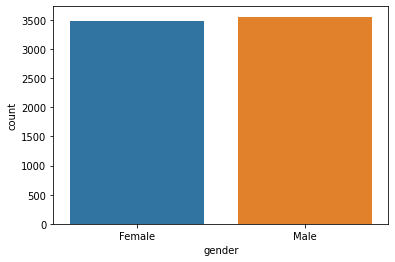



Partner
-------------------------
     Count  Ratio
No    3641 51.697
Yes   3402 48.303




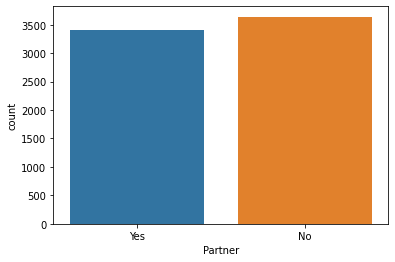



Dependents
-------------------------
     Count  Ratio
No    4933 70.041
Yes   2110 29.959




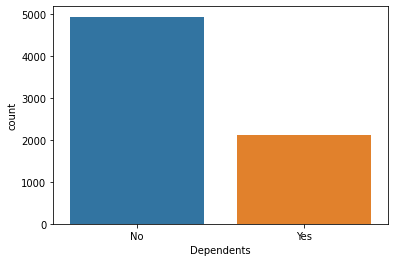



PhoneService
-------------------------
     Count  Ratio
Yes   6361 90.317
No     682  9.683




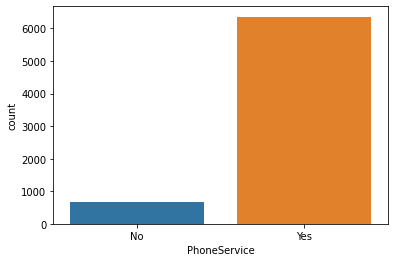



MultipleLines
-------------------------
                  Count  Ratio
No                 3390 48.133
Yes                2971 42.184
No phone service    682  9.683




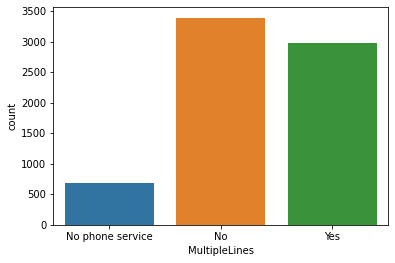



InternetService
-------------------------
             Count  Ratio
Fiber optic   3096 43.959
DSL           2421 34.375
No            1526 21.667




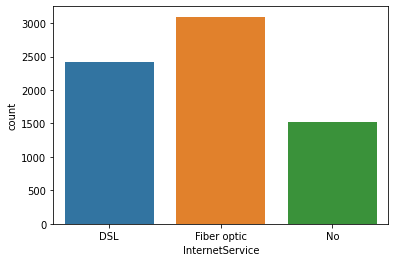



OnlineSecurity
-------------------------
                     Count  Ratio
No                    3498 49.666
Yes                   2019 28.667
No internet service   1526 21.667




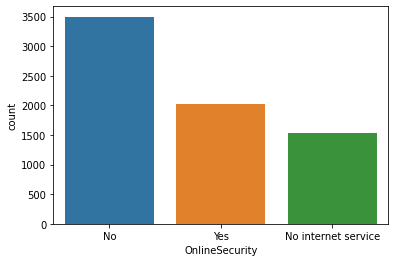



OnlineBackup
-------------------------
                     Count  Ratio
No                    3088 43.845
Yes                   2429 34.488
No internet service   1526 21.667




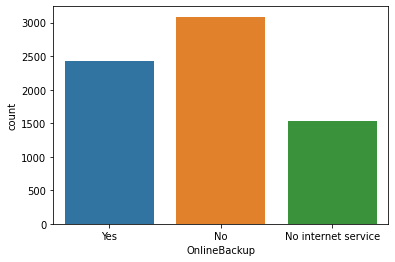



DeviceProtection
-------------------------
                     Count  Ratio
No                    3095 43.944
Yes                   2422 34.389
No internet service   1526 21.667




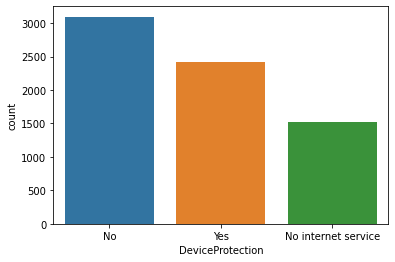



TechSupport
-------------------------
                     Count  Ratio
No                    3473 49.311
Yes                   2044 29.022
No internet service   1526 21.667




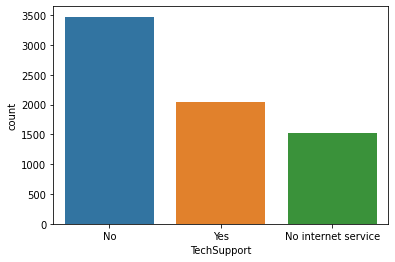



StreamingTV
-------------------------
                     Count  Ratio
No                    2810 39.898
Yes                   2707 38.435
No internet service   1526 21.667




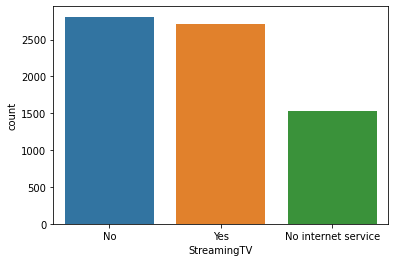



StreamingMovies
-------------------------
                     Count  Ratio
No                    2785 39.543
Yes                   2732 38.790
No internet service   1526 21.667




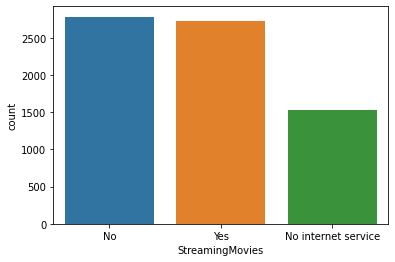



Contract
-------------------------
                Count  Ratio
Month-to-month   3875 55.019
Two year         1695 24.066
One year         1473 20.914




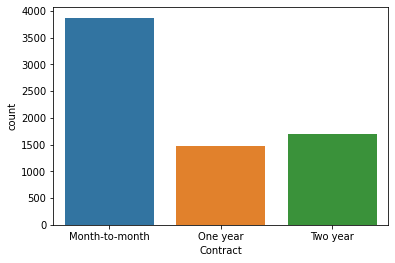



PaperlessBilling
-------------------------
     Count  Ratio
Yes   4171 59.222
No    2872 40.778




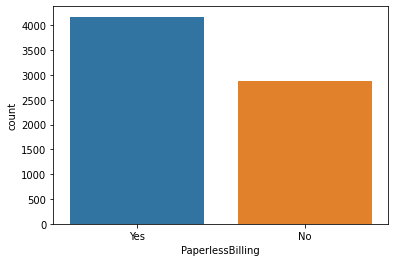



PaymentMethod
-------------------------
                           Count  Ratio
Electronic check            2365 33.579
Mailed check                1612 22.888
Bank transfer (automatic)   1544 21.922
Credit card (automatic)     1522 21.610




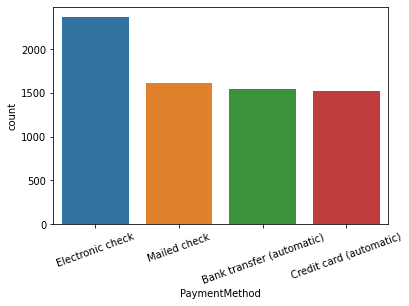



SeniorCitizen
-------------------------
   Count  Ratio
0   5901 83.785
1   1142 16.215




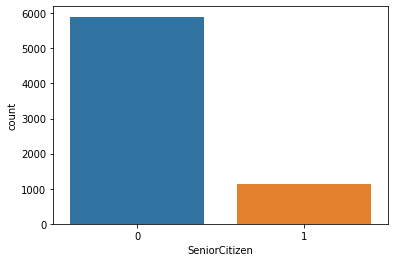



Churn
-------------------------
   Count  Ratio
0   5174 73.463
1   1869 26.537




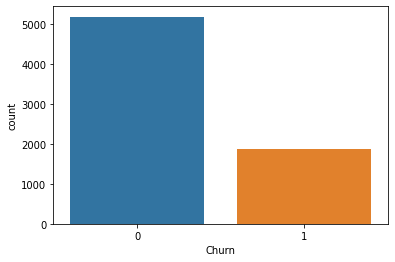

In [17]:
cat_summary(df, cat_cols, plot=True)

In [18]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

tenure
---------------
count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


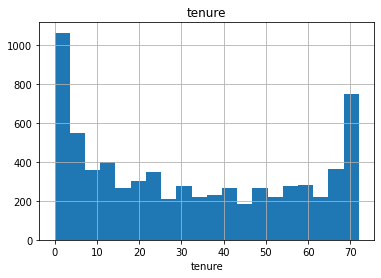

MonthlyCharges
---------------
count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


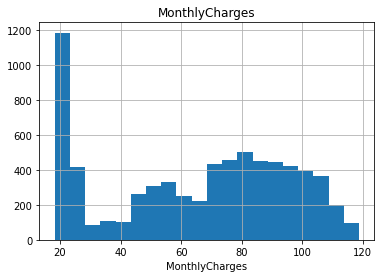

TotalCharges
---------------
count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


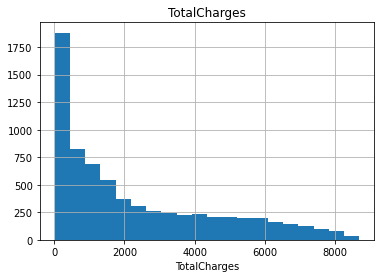

In [19]:
for col in num_cols:
    print(col)
    print(15*"-")
    num_summary(df, col, plot=True)

In [20]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(f'\033[1m' +f'{categorical_col}'+'\033[0m')
    print(30*"-")
    print(pd.DataFrame({"Target Mean": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")
    if plot:
        sns.countplot(x=dataframe[col], hue=dataframe["Churn"], data=dataframe)
        plt.legend(title='Churn', loc='upper right', labels=['No', 'Yes'])
        if col == "PaymentMethod":
            plt.xticks(rotation=20)
        plt.show()
        print("\n")

gender
------------------------------
        Target Mean  Count  Ratio
Female        0.269   3488 49.524
Male          0.262   3555 50.476




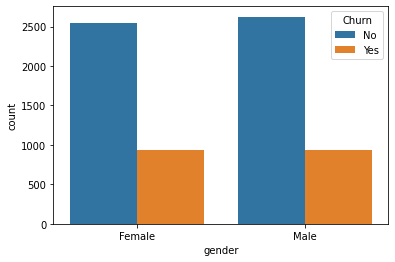



Partner
------------------------------
     Target Mean  Count  Ratio
No         0.330   3641 51.697
Yes        0.197   3402 48.303




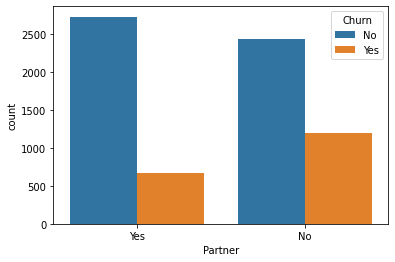



Dependents
------------------------------
     Target Mean  Count  Ratio
No         0.313   4933 70.041
Yes        0.155   2110 29.959




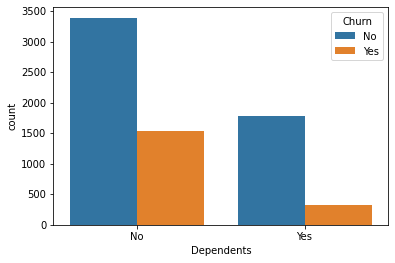



PhoneService
------------------------------
     Target Mean  Count  Ratio
No         0.249    682  9.683
Yes        0.267   6361 90.317




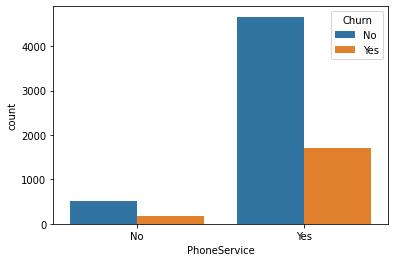



MultipleLines
------------------------------
                  Target Mean  Count  Ratio
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184




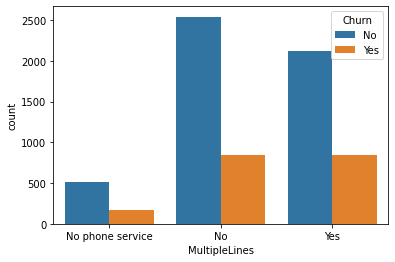



InternetService
------------------------------
             Target Mean  Count  Ratio
DSL                0.190   2421 34.375
Fiber optic        0.419   3096 43.959
No                 0.074   1526 21.667




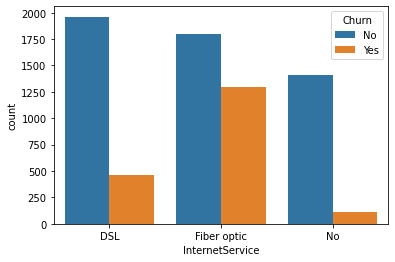



OnlineSecurity
------------------------------
                     Target Mean  Count  Ratio
No                         0.418   3498 49.666
No internet service        0.074   1526 21.667
Yes                        0.146   2019 28.667




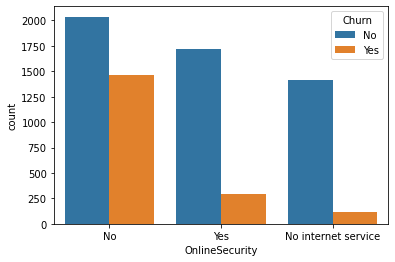



OnlineBackup
------------------------------
                     Target Mean  Count  Ratio
No                         0.399   3088 43.845
No internet service        0.074   1526 21.667
Yes                        0.215   2429 34.488




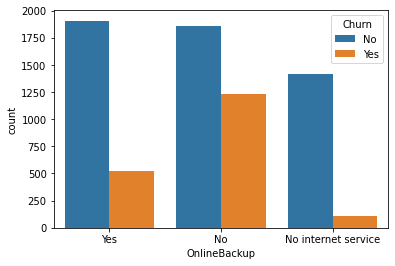



DeviceProtection
------------------------------
                     Target Mean  Count  Ratio
No                         0.391   3095 43.944
No internet service        0.074   1526 21.667
Yes                        0.225   2422 34.389




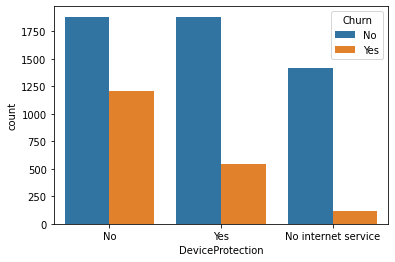



TechSupport
------------------------------
                     Target Mean  Count  Ratio
No                         0.416   3473 49.311
No internet service        0.074   1526 21.667
Yes                        0.152   2044 29.022




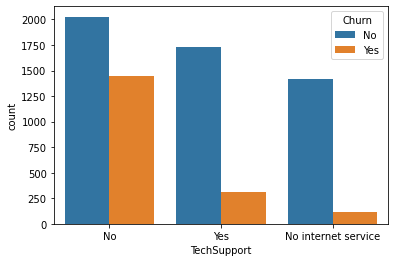



StreamingTV
------------------------------
                     Target Mean  Count  Ratio
No                         0.335   2810 39.898
No internet service        0.074   1526 21.667
Yes                        0.301   2707 38.435




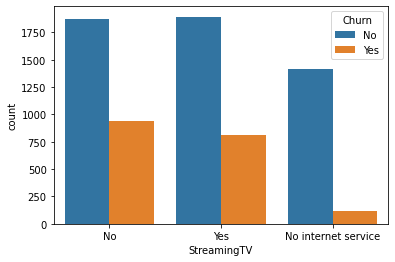



StreamingMovies
------------------------------
                     Target Mean  Count  Ratio
No                         0.337   2785 39.543
No internet service        0.074   1526 21.667
Yes                        0.299   2732 38.790




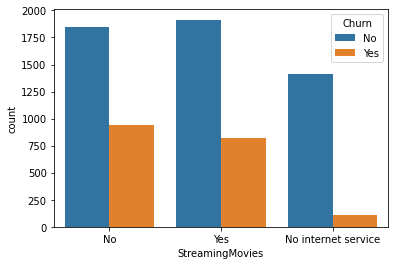



Contract
------------------------------
                Target Mean  Count  Ratio
Month-to-month        0.427   3875 55.019
One year              0.113   1473 20.914
Two year              0.028   1695 24.066




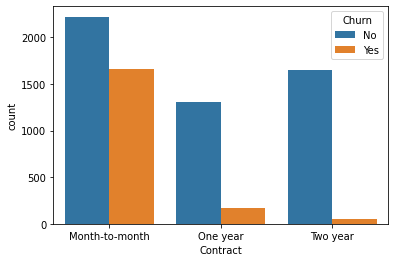



PaperlessBilling
------------------------------
     Target Mean  Count  Ratio
No         0.163   2872 40.778
Yes        0.336   4171 59.222




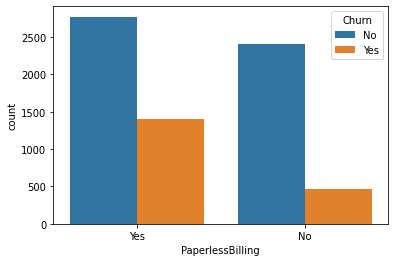



PaymentMethod
------------------------------
                           Target Mean  Count  Ratio
Bank transfer (automatic)        0.167   1544 21.922
Credit card (automatic)          0.152   1522 21.610
Electronic check                 0.453   2365 33.579
Mailed check                     0.191   1612 22.888




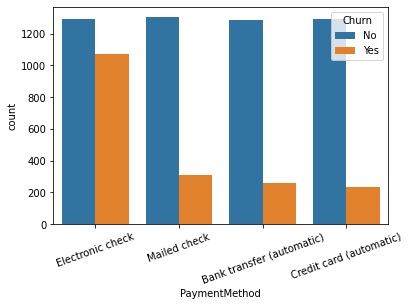



SeniorCitizen
------------------------------
   Target Mean  Count  Ratio
0        0.236   5901 83.785
1        0.417   1142 16.215




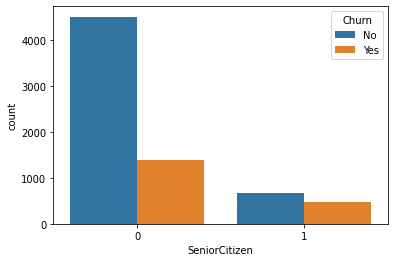

In [21]:
for col in cat_cols:
    if col == "Churn":
        continue
    target_summary_with_cat(df, "Churn", col, plot=True)

In [22]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [23]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




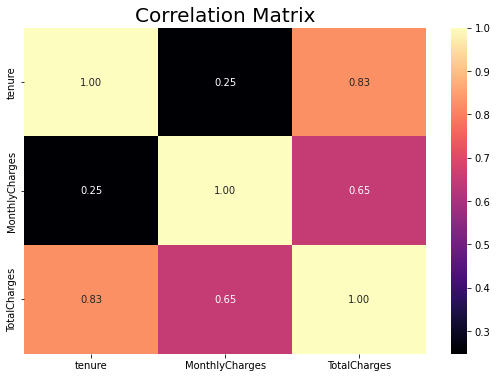

In [24]:
f, ax = plt.subplots(figsize=[9, 6])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [25]:
df.corrwith(df["Churn"]).sort_values(ascending=False)

Churn             1.000
MonthlyCharges    0.193
SeniorCitizen     0.151
TotalCharges     -0.199
tenure           -0.352
dtype: float64

In [26]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [27]:
na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11  0.160


In [28]:
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,0


In [29]:
df["TotalCharges"].fillna(0, inplace=True)

In [30]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [31]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [32]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [33]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


In [34]:
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [35]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year


In [36]:
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [37]:
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)


In [38]:
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)


In [39]:
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [40]:
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [41]:
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [42]:
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] )
df.loc[df["tenure"]==0, "NEW_AVG_Charges"] = 0

In [43]:
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

In [44]:
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [45]:
df["NEW_PD"] = df.apply(lambda x: 1 if (x["Partner"]== "No") & (x["Dependents"]=="No") else 0, axis=1)

In [46]:
df["NEW_EP"] = df.apply(lambda x: 1 if (x["PaperlessBilling"]== "Yes") & (x["PaymentMethod"]=="Electronic check ") else 0, axis=1)

In [47]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 33
cat_cols: 26
num_cols: 6
cat_but_car: 1
num_but_cat: 10


In [48]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [49]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [50]:
for col in binary_cols:
    df = label_encoder(df, col)

In [51]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment',
 'NEW_PD',
 'NEW_EP']

In [52]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [53]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [54]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1,NEW_PD_1
0,7590-VHVEG,0,1,0,1,0,1,29.850,29.850,0,1,29.850,1.000,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
1,5575-GNVDE,1,0,0,34,1,0,56.950,1889.500,0,3,55.574,0.976,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
2,3668-QPYBK,1,0,0,2,1,1,53.850,108.150,1,3,54.075,1.004,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
3,7795-CFOCW,1,0,0,45,0,0,42.300,1840.750,0,3,40.906,0.967,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1
4,9237-HQITU,0,0,0,2,1,1,70.700,151.650,1,1,75.825,1.072,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1


In [55]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [57]:
X_train.shape

(4930, 45)

In [58]:
y_train.shape

(4930,)

In [59]:
X_test.shape

(2113, 45)

In [60]:
y_test.shape

(2113,)

In [61]:
catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [62]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")


Accuracy: 0.8
Recall: 0.67
Precision: 0.51
F1: 0.58
Auc: 0.75


In [63]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

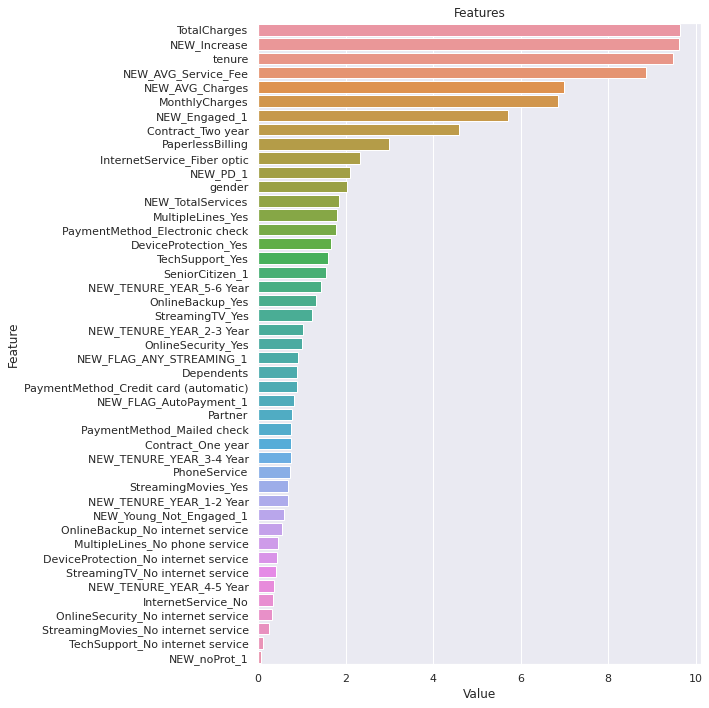

In [64]:
plot_importance(catboost_model, X)